# COMP24112 - Exercise 3: _Face Recognition_ (25 Marks)

## 1. Task description

You will work on the face recognition and face completion tasks. The provided dataset includes face images of 40 subjects. There are a total of 400 images, with 10 images per subject. Each image contains 32×32=1024 pixels, with 256 grey levels per pixel.

You will be marked for your code presentation, design, results, and report. Please note this notebook should take no more than 10 minutes to run on lab computers. 

## 2. Preparation

### 2.1 Setting up

The functions that you need are defined in the source file we have provided you with. To use them you must import it first:

In [1]:
from lab3lib import load_data, show_single_face, show_faces, partition_data, split_left_right, join_left_right, show_split_faces
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix



Now you can load the data:

In [2]:
data, labels = load_data()

### 2.2 Visualising the dataset

You can observe the faces stored in a data matrix by using the functions `show_single_face()` and `show_faces()`.

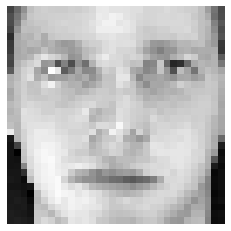

In [3]:
# Display a single example.
show_single_face(data[0, :])

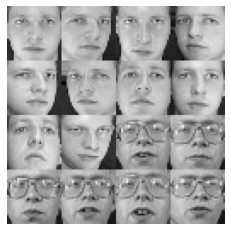

In [4]:
# Display the first 16 examples in a 4x4 grid.
show_faces(data[:16, :], num_per_row=4)

### 2.3 Splitting into the train and test sets

First, normalize your pixel values by 1/255 so that the feature values used in later experiments are between $[0,1]$. In general, the normalization trick can make it easier for your to tune parameters in machine learning experiments.

A data partition function is supplied to facilitate your experiments. It randomly splits the provided data into the training and test sets, where the training set contains $N$ samples per class and the test set contains
the remaining samples. The function takes the labels and the specified number $N$ as the input. And returns the sample indices in the training and test set. For example, the following code divides a given set of 400 samples into a training set containing 3 samples per subject and a test set containing 7 samples per subject:

In [5]:
# normalization
data = data / 255



# partition
tr_ind, te_ind = partition_data(labels, num_per_class=3)
tr_data = data[tr_ind, :]
tr_label = labels[tr_ind]
te_data = data[te_ind, :]
te_label = labels[te_ind]

## 3. $L_2$-regularised least squares (5 marks, Normal)
### 3.1 Implementation
Now, you need to implement the function `l2_rls_train` below. 

`l2_rls_train` trains a linear model by minimising the $L_2$-regularised sum of squares loss through zeroing the loss gradient. It should support both single-output and multi-output cases. This function should take a set of training samples and a user-specified regularisation parameter $\lambda$ (lambda) as the input, and return the predicted weights. When $\lambda=0$, use a pseudo-inverse to implement the solution.

In [6]:
def l2_rls_train(data, labels, lmbd):
    """
    Trains a linear model using regularized least squares.

    data: Input data matrix of shape (m, n), where m is the number of samples and n is the number of features.
    labels: Target labels of shape (m, types)# for the data samples, where types is the number of classes.
    lmbd: Regularization parameter.

    Returns:
    w: Weight vector of shape (n + 1, types) for the linear model.
    """
    X, y = data, labels

    # Expand X with a column of ones.
    X_tilde = np.insert(X, 0, 1, axis=1)

    # Compute the coefficient vector using regularized least squares.
    identity_matrix = np.identity(X_tilde.shape[1])
    pseudo_inverse = np.linalg.pinv(X_tilde)
    if lmbd!=0:
        
        w = np.linalg.inv(X_tilde.T @ X_tilde + lmbd * identity_matrix) @ X_tilde.T @ y
    else:
        w= pseudo_inverse@y
        

    return w


In [7]:
w = l2_rls_train(tr_data , tr_label , 0)
print(len(w))

1025


Now, implement the function `l2_rls_predict` below. It should take the trained weights and your query data as the input, and return the corresponding prediction.

In [8]:
def l2_rls_predict(w, data):
    """
    Predicts the output labels for the given data using the trained weights.

    Parameters:
    w (numpy.ndarray): The weight vector obtained from training.
    data (numpy.ndarray): The input data for which predictions are to be made.

    Returns:
    numpy.ndarray: The predicted output labels.
    """
    
    # Compute the prediction by multiplying the input data with the weight vector.
    X = data  # Input data
    X_tilde = np.insert(X, 0, 1, axis=1)  # Add a column of ones to the input data matrix

    # Multiply the input data matrix with the weight vector to obtain the predictions
    predicted_y = X_tilde @ w
    
    return predicted_y


In [9]:
p= l2_rls_predict(w,te_data)
print(len(p))

280


### 3.2 Report

Explain briefly the knowledge supporting your implementation and your design step by step. Explicitly comment on the role of any arguments you have added to your functions. 

## 4. Face Recognition (4 Marks, Normal)
### 4.1 Implementation and experiment design

Use your implemented functions to perform multi-class classification to identify the subject in each image, for all 40 subjects.

Split your data to two sets: the training set contains 5 randomly selected images per subject and the test set contains the remaining images. The training set is used to train the model and select hyper-parameter $\lambda$, while the test set is only for final assessment of the trained classifier with the selected $\lambda$. 

Design an appropriate and complete machine learning experiment, which should include the training, hyper-parameter selection and evaluation stages. You can choose from the random subsampling, $k$-fold CV and LOO approaches for hyper-parameter selection. In the evaluation, you should construct a $40\times 40$ classification error matrix (confusion matrix) for test samples. 

Write your code below and make sure it compiles. 

In [10]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix


def one_hot_encoding(labels):
    # Determine the number of classes
    number_of_classes = np.max(labels) + 1
    # Create a one-hot matrix of zeros with the shape (number of samples, number of classes)
    one_hot_matrix = np.zeros((len(labels), number_of_classes))
    # Set the corresponding positions to 1 based on the labels
    one_hot_matrix[np.arange(len(labels)), labels] = 1
    return one_hot_matrix

def hyperparameter_selection(train_data, train_labels, lambdas, splits=5):
    number_of_train_data = len(train_data)
    num_val = number_of_train_data // splits
    error_values_list = []
    for i in range(splits):
        errors = []
        # Split the data into training and validation sets
        train_index_errors, value_index = partition_data(train_label, num_per_class=3)
        train_data_one, value_data = train_data[train_index_errors], train_data[value_index]
        train_label_one, value_label_one = train_label[train_index_errors], train_label[value_index]
        for lmbd in lambdas:
            # Train the model with the current lambda regularization parameter
            w = l2_rls_train(train_data_one, train_label_one, lmbd)
            # Make predictions on the validation set
            prediction_labels = l2_rls_predict(w, value_data)
            # Calculate the number of misclassified samples and divide by the total number of samples to get the error rate
            number_of_errors_one = np.count_nonzero(prediction_labels != value_label_one)
            error_rate = number_of_errors_one / len(value_label_one)
            errors.append(error_rate)
        # Calculate the mean error for the current split and add it to the list of errors
        error_values_list.append(np.mean(errors))
        
    # Find the index of the lambda with the lowest mean error
    best_lambda_index = np.argmin(error_values_list)
    return lambdas[best_lambda_index]

# Partition the data into training and test sets
train_index_two, test_index_two = partition_data(labels, num_per_class=5)
train_data = data[train_index_two, :]
train_label = labels[train_index_two]
train_label_partitioner = train_label
test_data = data[test_index_two, :]
test_label = labels[test_index_two]

# Encode the training and test labels using one-hot encoding
train_labels_enc = one_hot_encoding(train_label)
test_labels_enc = one_hot_encoding(test_label)

lambdas = []
for i in range(-8, 20, 1):
    lambdas.append(10 ** i)

# Perform hyperparameter selection to find the best lambda regularization parameter
best_lambda = hyperparameter_selection(train_data, train_label, lambdas)
print("Best Lambda: ", best_lambda)

# Train the model using the best lambda regularization parameter
w = l2_rls_train(train_data, train_labels_enc, best_lambda)

# Make predictions on the test set
predicted_labels_encoded = l2_rls_predict(w, test_data)
predicted_labels = np.argmax(predicted_labels_encoded, axis=1)

# Calculate and print the confusion matrix
conf_mat = confusion_matrix(test_label, predicted_labels)
print("Confusion matrix:")
print(conf_mat)

# Calculate the number of misclassified samples in the test set
number_of_errors_test = np.count_nonzero(predicted_labels != test_label)
# Calculate the error rate by dividing the number of misclassified samples by the total number of samples
error_rate_test = number_of_errors_test / len(test_label)
print("Test error",error_rate_test)


# Calculate the accuracy by subtracting the error rate from 1 
accuracy = (1 - error_rate_test) 

# Print the accuracy of the best lambda in percentage
print("The accuracy of the best lambda is {:.2%}".format(accuracy))







Best Lambda:  1e-08
Confusion matrix:
[[2 0 0 ... 0 0 0]
 [1 4 0 ... 0 0 0]
 [0 0 4 ... 0 0 0]
 ...
 [0 0 0 ... 5 0 0]
 [0 0 0 ... 0 5 0]
 [0 0 0 ... 0 0 3]]
Test error 0.055
The accuracy of the best lambda is 94.50%


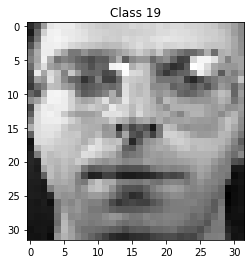

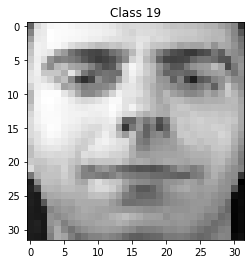

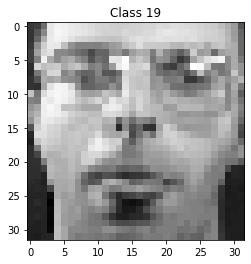

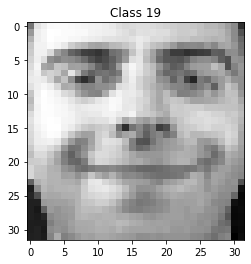

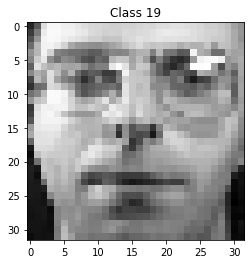

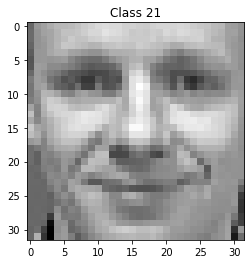

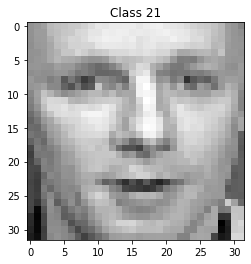

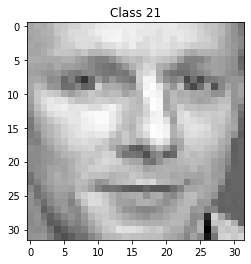

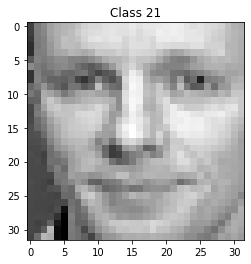

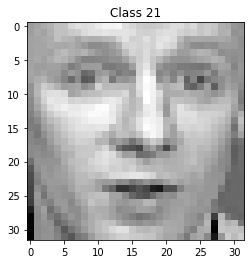

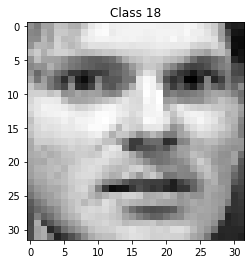

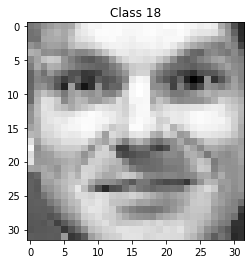

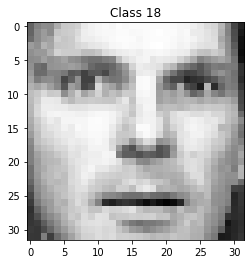

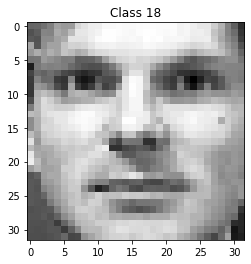

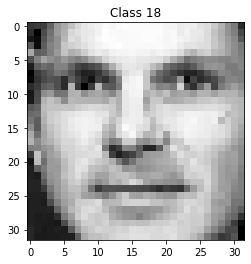

In [11]:
# Find the easiest subjects to recognize by identifying classes with the highest diagonal values in the confusion matrix
diag_indices = np.argsort(np.diag(conf_mat))[::-1]
# Pick the top 3 easiest classes
easiest_classes = diag_indices[:3]


# Print the test images from these classes
for i in easiest_classes:
    # Find the indices of test images belonging to the current easiest class
    indices = np.where(test_label == i)[0][:5]  # Pick the first 5 images of the class
    for j in indices:
        # Display the image and add a title indicating the class
        plt.imshow(test_data[j].reshape(32, 32), cmap='gray')
        plt.title(f"Class {i}")
        plt.show()


In [12]:
diag_indices = np.argsort(np.diag(conf_mat))
# Picking top 3 most difficult classes
difficult_classes = diag_indices[-3:]  # Use negative indexing to select the last 3 classes

# Print the misclassified test images from these classes
for i in difficult_classes:
    # Finding indices of misclassified labels
    indices = np.where((predicted_labels != test_label) & (test_label == i))[0]
    for j in indices:
        plt.imshow(test_data[j].reshape(32, 32), cmap='gray')
        plt.title(f"Misclassified as {predicted_labels[j]}, Actual {test_label[j]}")
        plt.show()


 Pick some subjects that are considered the easist to recognise by your classifier, and print the test images from these subjects below.

Pick some subjects that are considered hard to recognise by your classifier, and print the test images from these subjects below.

### 4.2 Report

Explain the classification steps, and report your chosen hyper-parameter and results on the test set. Did you notice any common features among the easiest and most difficult subjects to classify? Describe your observations and analyse your results.

## 5. Face Completion (4 Marks, Normal)
In this task you will predict the 512 pixels of the right face from the 512 pixels of the left face by formulating a regression task.

The following command can be used to extract the left and right faces from the input data.

In [13]:
left, right = split_left_right(data)


And you can visualise them with the function `show_split_faces()`:

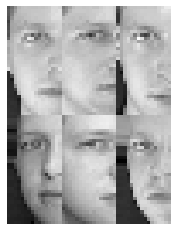

In [14]:
show_split_faces(left[:6, :], num_per_row=3)


### 5.1 Implementation and experiment design

Build a face completion model using your regularised least squares model. Design an experiment to assess your model, which should include appropriate training and testing. Use mean absolute percentage error (MAPE) to evaluate the regression performance. You do not need to bother with hyper-parameter selection, but simply set $\lambda$=0.

Write your code below and make sure it compiles.

In [15]:
# Splitting the left and right faces into training and testing sets
# Partition the data into training and testing indices
train_indices, test_indices = partition_data(labels, num_per_class=5)

# Get the corresponding left and right training data
train_left = left[train_indices, :]
train_right = right[train_indices, :]

# Get the corresponding left and right testing data
test_left = left[test_indices, :]
test_right = right[test_indices, :]

# Alternatively, split the given training and testing data into left and right parts
tr_left_data, tr_right_data = split_left_right(tr_data)
te_left_data, te_right_data = split_left_right(te_data)

# Train the face completion model using regularized least squares with lambda = 0
w = l2_rls_train(tr_left_data, tr_right_data, 0)

# Use the trained model to predict the right faces for the testing data
predicted_right_faces = l2_rls_predict(w, te_left_data)

# Calculate the mean absolute percentage error (MAPE) between the predicted and actual right faces
mape = np.mean(np.abs((te_right_data - predicted_right_faces) / te_right_data))
print("Mean Absolute Percentage Error (MAPE): ", mape * 100)

Mean Absolute Percentage Error (MAPE):  21.179221793130722


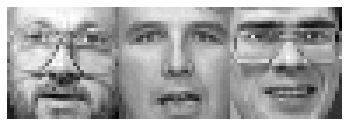

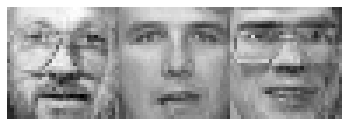

In [16]:
random_indices = np.random.choice(200, 3)

# Join the left and predicted right faces to obtain the predicted faces
predicted_face = join_left_right(te_left_data, predicted_right_faces)

# Compare the actual faces to the predicted faces
# Print the actual faces in the first row
show_faces(te_data[random_indices], num_per_row=3)
# Print the predicted faces in the second row
show_faces(predicted_face[random_indices], num_per_row=3)

Visualise and compare the ground truth face (include both the left and right parts) and the completed face (include both the true left and predicted right parts) for 3 randomly chosen testing samples below. You can use `join_left_right(left, right)` to concatenate the left and right halves of a set of faces.

### 5.2 Report

Report the MAPE and make some observations regarding the results of the face completion model. How well has your model performed? Offer one suggestion for how it can be improved.


## 6. Training linear least squares model via gradient descent (5 marks, Normal)
For these experiments you will be performing **binary classification.** 
### 6.1 GD Implementation
Now, implement the function `lls_gd_train` below. 

`lls_gd_train` trains a single-output linear model by minimising the sum of squares loss using the gradient descent approach. It should take the iteration number $N$ and the learning rate $\eta$ as the input. To keep things simple, you can fix the initial guess of the model weights $\mathbf{w}$ as zeros. It should record and return the weights and costs of linear least squares model calculated in all the iterations.

In [17]:
def lls_gd_train(data, labels, N, learning_rate):
    """
    Trains a linear model using the method of gradient descent for the linear least squares problem.

    Parameters:
    data (numpy.ndarray): The input data matrix.
    labels (numpy.ndarray): The output labels corresponding to the input data.
    N (int): The number of iterations for gradient descent.
    learning_rate (float): The learning rate or step size for gradient descent.

    Returns:
    tuple: A tuple containing two numpy arrays. The first array contains the cost function values at each iteration,
           and the second array contains the weight vectors at each iteration.
    """
    # This is just to be consistent with the lecture notes.
    X, y = data, labels
    
    # Expand X with a column of ones.
    X_tilde = np.insert(X, 0, 1.0, axis=1)
    
    # Weight initialization
    w = np.zeros((X_tilde.shape[1],))

    # Initialise arrays to store weights and cost at each iteration
    # Each row of w_all corresponds to weights at a specific iteration
    w_all = np.zeros((N, X_tilde.shape[1]))
    # Stores cost of linear model at a specific iteration
    cost_all = np.zeros((N,))
    
    # GD update of weights
    for i in range(N):
        # cost and gradient descent of the linear least squares model
        gd = (X_tilde.T @ X_tilde @ w) - (X_tilde.T @ y)
        # Cost function of linear least squares model
        cost = 0.5 * np.sum(((l2_rls_predict(w.T, X))-y)**2)
        
        # Weight update
        w = w - (learning_rate * gd)
        
        # save w and cost of each iteration in w_all and cost_all 
        w_all[i] = w
        cost_all[i] = cost
    
    # Return model parameters.
    return cost_all, w_all


### 6.2 Experiments

Apply this function to classify images from subject 1 and subject 30. You only need to conduct the experiment for one training-test trial, where 3 images from each subject are used for training and the remaining 7 images for testing.

Set your learning rate small, e.g., $\eta=10^{-3}$, and use a reasonable iteration number, e.g., $N=200$, to train your model. Plot in three figures (1) the change of your sum-of-squares error loss that you minimise, (2) the change of the classification accuracy for training samples, and (3) the change of the classification accuracy for test samples over iterations. Write your code below and make sure it runs. 

Try a larger learning rate, e.g., $\eta=10^{-2}$, and produce the same three plots by training the model for $N=200$ iterations. Write your code below and make sure it runs. 

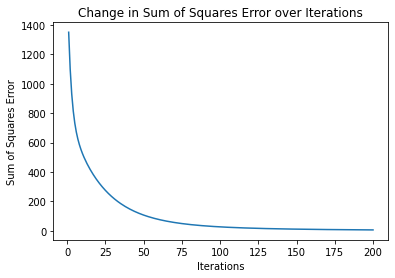

In [18]:
# Split the data into training and test sets
train_indices, test_indices = partition_data(labels, num_per_class=3)
train_data = data[train_indices]
train_labels = labels[train_indices]
test_data = data[test_indices]
test_labels = labels[test_indices]

# Filter the training and test data based on specific labels (1 and 30)
train_data_filtered = train_data[np.where((train_labels == 1) | (train_labels == 30))]
test_data_filtered = test_data[np.where((test_labels == 1) | (test_labels == 30))]
train_labels_filtered = train_labels[np.where((train_labels == 1) | (train_labels == 30))]
test_labels_filtered = test_labels[np.where((test_labels == 1) | (test_labels == 30))]

# Train the model on the filtered training data
N = 200  # Number of iterations for training
learning_rate = 0.001  # Learning rate for gradient descent
train_cost, train_w_all = lls_gd_train(train_data_filtered, train_labels_filtered, N, learning_rate)

# Plotting the change of sum-of-squares error loss over iterations
x = np.arange(1, N+1)
plt.plot(x, train_cost)
plt.xlabel('Iterations')
plt.ylabel('Sum of Squares Error')
plt.title('Change in Sum of Squares Error over Iterations')
plt.show()

# Calculating change in classification accuracy for the filtered training samples over iterations


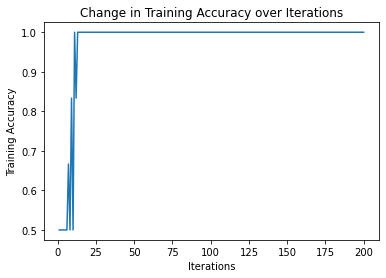

In [19]:
train_accuracy = []
threshold = 15.5  # Threshold value to classify predictions as label 1 or label 30

for w in train_w_all:
    correct = 0  # Counter for correctly classified samples
    pred_labels = l2_rls_predict(w, train_data_filtered)  # Predict labels using the current weights
    for i in range(len(pred_labels)):
        if pred_labels[i] < threshold:
            pred_labels[i] = 1  # Classify predictions less than threshold as label 1
        else:
            pred_labels[i] = 30  # Classify predictions greater than or equal to threshold as label 30
        if pred_labels[i] == train_labels_filtered[i]:  # Check if the prediction matches the true label
            correct += 1  # Increment the counter for correct classification
    accuracy = correct / len(train_labels_filtered)  # Calculate the accuracy for the current iteration
    train_accuracy.append(accuracy)  # Append the accuracy to the list of training accuracies

# Plotting change in classification accuracy for the filtered training samples over iterations
plt.plot(x, train_accuracy)
plt.xlabel('Iterations')
plt.ylabel('Training Accuracy')
plt.title('Change in Training Accuracy over Iterations')
plt.show()





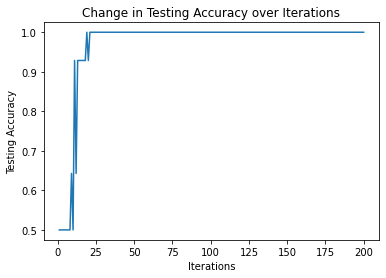

In [20]:

# Calculating change in classification accuracy for the filtered test samples over iterations 
# the code executed here is the same code as above 
test_accuracy = []

for w in train_w_all:
    correct = 0
    pred_labels = l2_rls_predict(w, test_data_filtered)
    for i in range(len(pred_labels)):
        if pred_labels[i] < threshold:
            pred_labels[i] = 1
        else:
            pred_labels[i] = 30
        if pred_labels[i] == test_labels_filtered[i]:
            correct += 1
    accuracy = correct / len(test_labels_filtered)
    test_accuracy.append(accuracy)

# Plotting change in classification accuracy for the filtered test samples over iterations
plt.plot(x, test_accuracy)
plt.xlabel('Iterations')
plt.ylabel('Testing Accuracy')
plt.title('Change in Testing Accuracy over Iterations')
plt.show()

<ipython-input-17-6ae8cf7d5f0f>:35: RuntimeWarning: overflow encountered in square
  cost = 0.5 * np.sum(((l2_rls_predict(w.T, X))-y)**2)


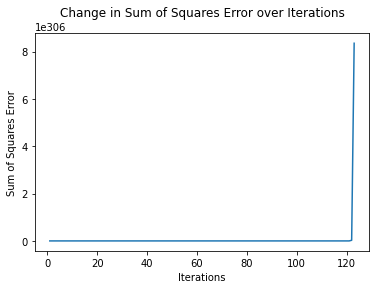

In [21]:
#The code provided is the same as above just the learning_rate= 0.01
# Split the data into training and test sets

train_indices, test_indices = partition_data(labels, num_per_class=3)
train_data = data[train_indices]
train_labels = labels[train_indices]
test_data = data[test_indices]
test_labels = labels[test_indices]

# Filter the training and test data based on specific labels
train_data_filtered = train_data[np.where((train_labels == 1) | (train_labels == 30))]
test_data_filtered = test_data[np.where((test_labels == 1) | (test_labels == 30))]
train_labels_filtered = train_labels[np.where((train_labels == 1) | (train_labels == 30))]
test_labels_filtered = test_labels[np.where((test_labels == 1) | (test_labels == 30))]

# Train the model on the training data
N = 200
learning_rate = 0.01
train_cost, train_w_all = lls_gd_train(train_data_filtered, train_labels_filtered, N, learning_rate)

# Plotting the change of sum-of-squares error loss that was minimized
x = np.arange(1, N+1)
plt.plot(x, train_cost)
plt.xlabel('Iterations')
plt.ylabel('Sum of Squares Error')
plt.title('Change in Sum of Squares Error over Iterations')
plt.show()




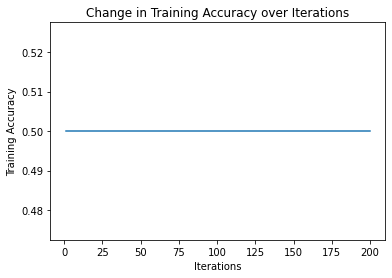

In [22]:
# Calculating change in classification accuracy for training samples over iterations
train_accuracy = []
threshold = 15.5

for w in train_w_all:
    correct = 0
    pred_labels = l2_rls_predict(w, train_data_filtered)
    for i in range(len(pred_labels)):
        if pred_labels[i] < threshold:
            pred_labels[i] = 1
        else:
            pred_labels[i] = 30
        if pred_labels[i] == train_labels_filtered[i]:
            correct += 1
    accuracy = correct / len(train_labels_filtered)
    train_accuracy.append(accuracy)

# Plotting change in classification accuracy for training samples over iterations
plt.plot(x, train_accuracy)
plt.xlabel('Iterations')
plt.ylabel('Training Accuracy')
plt.title('Change in Training Accuracy over Iterations')
plt.show()



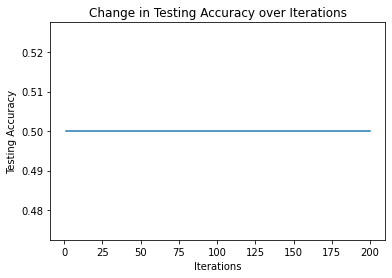

In [23]:
# Calculating change in classification accuracy for testing samples over iterations
test_accuracy = []

for w in train_w_all:
    correct = 0
    pred_labels = l2_rls_predict(w, test_data_filtered)
    for i in range(len(pred_labels)):
        if pred_labels[i] < threshold:
            pred_labels[i] = 1
        else:
            pred_labels[i] = 30
        if pred_labels[i] == test_labels_filtered[i]:
            correct += 1
    accuracy = correct / len(test_labels_filtered)
    test_accuracy.append(accuracy)

# Plotting change in classification accuracy for test samples over iterations
plt.plot(x, test_accuracy)
plt.xlabel('Iterations')
plt.ylabel('Testing Accuracy')
plt.title('Change in Testing Accuracy over Iterations')
plt.show()

### 6.3 Report

How did you choose the learning rate and iteration number? Explain your results.

## 7. Advanced Gradient-based Training
For this section, you may choose to implement **either Option 1: SGD** (4 marks), or **Option 2: GD with hinge loss** (7 marks). 

*Please note: Option 1 is easier, but gives fewer potential marks. Option 2 is designed to be a steep challenge, potentially involves mathematical derivations not shown in your notes, and will be marked rigorously. Choose wisely!*

### Option 1: Compare with stochastic gradient descent training (4 marks, Normal)
### 7.1 SGD Implementation 
Replace the gradient descent approach that you did in Section 4 with a stochastic gradient descent approach. Your new implementation can be named as `lls_sgd_train`. You can adopt a similar implementation template to that of your `lls_gd_train` function.

In [24]:
def lls_sgd_train(data, labels, N, learning_rate):
    """
    Trains a linear least squares model using stochastic gradient descent.

    Parameters:
    data (numpy.ndarray): The input data matrix.
    labels (numpy.ndarray): The output labels corresponding to the input data.
    N (int): The number of iterations for stochastic gradient descent.
    learning_rate (float): The learning rate or step size for stochastic gradient descent.

    Returns:
    tuple: A tuple containing two lists. The first list contains the cost values at each iteration,
           and the second list contains the weight vectors at each iteration.
    """
    # Separate the data and labels.
    X, y = data, labels

    # Expand X with a column of ones for the bias term.
    X_tilde = np.insert(X, 0, np.ones((1, 1), dtype=int), axis=1)

    # Initialize the weight vector with zeros.
    w = np.zeros(1025)

    # Initialize lists to store weights and costs at each iteration.
    w_all = []  # List to store weight vectors.
    cost_all = []  # List to store cost values.

    # Perform stochastic gradient descent updates for N iterations.
    for j in range(N):
        # Generate a random integer within the range of the number of rows in X_tilde.
        randomRow = np.random.randint(X_tilde.shape[0], size=1)

        # Retrieve the random row and its corresponding label.
        x_random = X_tilde[randomRow[0], :]  # Random row of X_tilde.
        y_random = y[randomRow]  # Corresponding label.

        # Compute the predicted gradient and posterior gradient.
        predicted_gradient = x_random.T * (x_random @ w)
        posterior_gradient = x_random.T * y_random

        # Compute the overall gradient as the difference between predicted and posterior gradients.
        gradient = predicted_gradient - posterior_gradient

        # Compute the cost by comparing predictions with the true labels.
        predictions = X_tilde @ w
        ans = np.sum((predictions - y_random))
        cost = (ans**2)/2

        # Update the weights using the gradient and learning rate.
        w = w - (learning_rate * gradient)

        # Save the updated weight vector and cost at each iteration.
        w_all.append(w)
        cost_all.append(np.mean(cost))

    # Return the list of costs and weight vectors.
    return cost_all, w_all


### 7.2 Experiment Design
Design and implement an appropriate experiment to demonstrate the performance and behaviour difference between gradient descent and stochastic gradient descent. 


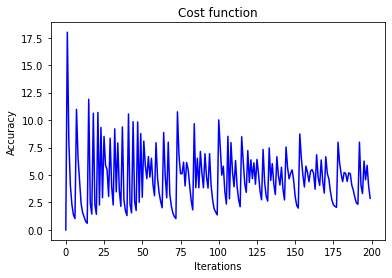

In [25]:
# Selecting data for image 1 and 3
sgd_data = np.take(data, range(15), axis=0)
sgd_data = np.concatenate((sgd_data, data[280:300, :]), axis=0)
sgd_labels = np.concatenate((np.ones(10), np.zeros(10)))

# Dividing the data into train and test split
train_indices_sgd, test_indices_sgd = partition_data(sgd_labels, num_per_class=3)
train_data_sgd = sgd_data[train_indices_sgd]
test_data_sgd = sgd_data[test_indices_sgd]
train_labels_sgd = sgd_labels[train_indices_sgd]
test_labels_sgd = sgd_labels[test_indices_sgd]

N = 200

# Training the model using stochastic gradient descent
cost_sgd, weight_sgd = lls_sgd_train(train_data_sgd, train_labels_sgd, N, 0.001)

# Plotting the change of the classification accuracy for training samples
x = np.arange(0, N)
y = cost_sgd
plt.title("Cost function")
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.plot(x, y, color="blue")
plt.show()


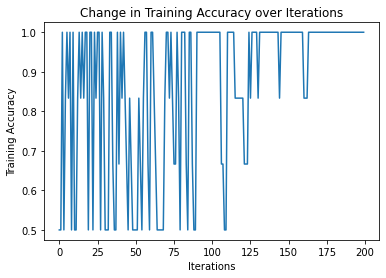

In [26]:
import time

# Selecting the data for image 1 and 3
sgd_data = np.take(data, range(15), axis=0)
sgd_data = np.concatenate((sgd_data, data[280:300, :]), axis=0)
sgd_labels = np.concatenate((np.ones(10), np.zeros(10)))

# Dividing the data into train and test split
train_indices_sgd, test_indices_sgd = partition_data(sgd_labels, num_per_class=3)
train_data_sgd = sgd_data[train_indices_sgd]
test_data_sgd = sgd_data[test_indices_sgd]
train_labels_sgd = sgd_labels[train_indices_sgd]
test_labels_sgd = sgd_labels[test_indices_sgd]


cost_sgd, weights_sgd = lls_sgd_train(train_data_sgd, train_labels_sgd, 200, 0.001)



# Compute the predictions for training and test data using the obtained weights at each iteration
predictions_train = []
predictions_test = []

for weight in weights_sgd:
    predictions_train.append(l2_rls_predict(weight, train_data_sgd))
    predictions_test.append(l2_rls_predict(weight, test_data_sgd))

# Calculate the accuracy for training and test data at each iteration
accuracy_train = []
accuracy_test = []

# Calculate accuracy for training data
for prediction in predictions_train:
    correct = 0
    for i in range(len(prediction)):
        if prediction[i] >= 0.5 and train_labels_sgd[i] == 1 or prediction[i] < 0.5 and train_labels_sgd[i] == 0:
            correct += 1
    accuracy_train.append(correct / len(prediction))

# Calculate accuracy for test data
for prediction in predictions_test:
    correct = 0
    for i in range(len(prediction)):
        if prediction[i] >= 0.5 and test_labels_sgd[i] == 1 or prediction[i] < 0.5 and test_labels_sgd[i] == 0:
            correct += 1
    accuracy_test.append(correct / len(prediction))

# Plot the change in accuracy over iterations for training data
x = np.arange(0, 200)
y_train = accuracy_train
plt.plot(x, y_train)
plt.xlabel('Iterations')
plt.ylabel('Training Accuracy')
plt.title('Change in Training Accuracy over Iterations')
plt.show()




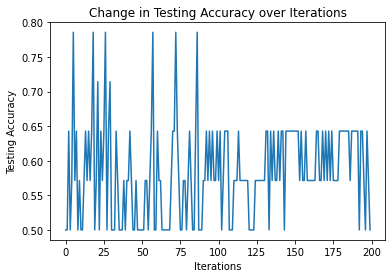

In [27]:
# Plot the change in accuracy over iterations for test data
y_test = accuracy_test
plt.plot(x, y_test)
plt.xlabel('Iterations')
plt.ylabel('Testing Accuracy')
plt.title('Change in Testing Accuracy over Iterations')
plt.show()

### 7.3 Report

Explain in the report your experiment design, comparative result analysis and interpretation of obtained results. Try to be thorough in your analysis.

**Remember that all graphs should have axis labels and a title.**

### Option 2: Gradient descent training using hinge loss (7 marks, Hard)
Here is a recap of Hinge loss. For a single output model, the hinge loss over N training samples is $$O(\theta) = \sum^N_{i=1}\max\left(0, 1 - y_i f(\theta, x_i)\right)$$ where $y_i \in \{-1, +1\}$ is the class target label and $f(\theta, x_i)$ is your prediction function. While this is not directly differentiable, we can split it into two separately differentiable parts. For one sample, the above formuation is equivalent to:
$$
\max\left(0, 1 - y_i f(\theta, x_i)\right) = \begin{cases}
    0 & \text{if } y_i f(\theta, x_i) \geq 1 \\ % & is your "\tab"-like command (it's a tab alignment character)
    1-y_i f(\theta, x_i) & \text{otherwise.}
\end{cases}
$$

### 7.1 Implementation
Apply the gradient descent approach to train your classifier but by minimising the hinge loss. Implement the function `hinge_gd_train` below. 

`hinge_gd_train` trains a single-output linear model by minimising the hinge loss using the gradient descent approach. The optimisation function should include a regularisation term and regularisation hyperparameter $C$. It should take the iteration number $N$, the learning rate $\eta$, and regularisation hyperparameter $C$ as arguments. To keep things simple, you can fix the initial guess of the model weights $\mathbf{w}$ as zeros. It should record and return the weights and costs of the regularised hinge loss model calculated in all the iterations.

In [28]:
def hinge_gd_train(data, labels, learning_rate, N # Add any other arguments here if needed
          ):
    """
    A summary of your function goes here.

    data: type and description of "data"
    labels: type and description of "labels"

    Returns: type and description of the returned variable(s).
    """
    # This is just to be consistent with the lecture notes.
    X, y = data, labels

    # Initialise arrays to store weights and cost at each iteration
    w_all = ...
    cost_all = ...

    # Your code goes here
    
    # GD update of weights
    for i in range(N):
        # cost and gradient descent of the linear hinge loss model
        cost = ...
        
        # save w and cost of each iteration in w_all and cost_all


    # Return model parameters.
    return cost_all, w_all


### 7.2 Experiment design
Design and implement an appropriate experiment to demonstrate the performance and behaviour difference for gradient descent training based on the least squared loss and the hinge loss. 


In [29]:
# Your code goes here


### 7.3 Report

Explain in your report the following: 

(1) Your implementation of `hinge_gd_train`. If you analytically derived the loss function, please include it here.

(2) Your experiment design, comparative result analysis and interpretation of obtained results. 

**Remember that all graphs should have axis labels and a title.**